In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import entropy, powerlaw
from scipy import interpolate
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
df = pd.read_csv('../../projects/data/bolcom-clicks-35m_test.txt', sep='\t')
df


,SessionId,Time,ItemId
0,0008019740_18,1585897352,9200000083733268
1,0008019740_18,1585897382,9200000049819763
2,0008019740_18,1585897392,9200000066323079
3,0008019740_18,1585897506,9200000081546242
4,0008019740_18,1585897633,9200000125623273
...,...,...,...
1211470,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921127,9200000065118578
1211471,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921160,9200000065118570
1211472,zzz7jpx6h6yk34srl558w4zg2eu4h4pm_1,1585921286,9200000064417495
1211473,zzzjsuzmx87wcp4720be75zq67m2hkx9_14,1585944407,9200000026328200


In [3]:
def create_index_df_from_column(argument_df, columnname):
    # create an index for the training item_ids, because we need this when training the model
    # this should be part of the train and serve code of an algorithm
    # usage:
    #     create_index_df_from_column(df, 'ItemId')
    # returns a two column dataframe:
    #   ItemId  idx
    #   9200000105095118    0
    #   9200000041902190    1
    #   9200000095595490    2
    token_id = {t: i for i, t in enumerate(argument_df[columnname].unique())}
    df_index = pd.DataFrame.from_dict(token_id, orient="index").reset_index()
    df_index.rename(columns={"index": columnname, 0: "idx"}, inplace=True)
    return df_index

In [4]:
item_pop_df = df.groupby('ItemId').size()
item_pops_df = item_pop_df.to_frame('qty').reset_index()
item_pops_df.sort_values(by=['qty'], inplace=True)
item_idx = create_index_df_from_column(item_pops_df, 'ItemId')
dfs = item_pops_df.merge(item_idx, on='ItemId')
dfs

,ItemId,qty,idx
0,9200000092996478,1,0
1,9200000066211433,1,1
2,9200000123889779,1,2
3,9200000066211493,1,3
4,9200000066211497,1,4
...,...,...,...
338412,9200000110533529,2073,338412
338413,9200000056292168,2177,338413
338414,9200000026848187,2186,338414
338415,9200000047735877,2224,338415


In [5]:
# Observed frequencies to observed probability
f_obs = dfs['qty'].to_numpy()
idx_list = dfs['idx'].to_numpy()
p_obs = f_obs / np.sum(f_obs)
p_obs = np.sort(p_obs)
p_obs = p_obs / np.sum(p_obs)

In [23]:
# Fit the power law distribution to the observed probability of the items 
fit_params = powerlaw.fit(f_obs)

In [38]:
f_obs

array([   1,    1,    1, ..., 2186, 2224, 2336])

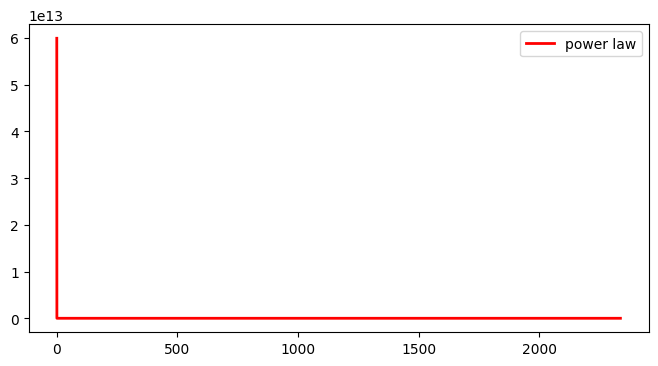

In [40]:
# plot the data and fitted power law distribution
x = np.linspace(f_obs.min(), f_obs.max(), 10000)
fig, ax = plt.subplots(figsize=(8, 4))
#ax.hist(f_obs, bins=10, density=True, alpha=1, label='histogram')
pdf = stats.powerlaw.pdf(x, *fit_params)
ax.plot(x, pdf, 'r-', lw=2, label='power law')
ax.legend()
plt.show()

In [7]:
# Generate frequencies for new items
m = 500000  # number of new items
p_new = powerlaw.rvs(*fit_params, size=m)
p_new

array([8.25440063e-07, 8.25440063e-07, 8.25440064e-07, ...,
       9.60326719e-05, 9.58284243e-04, 8.25440063e-07])

In [8]:
# Combine the observed and new item frequencies
p_all = np.concatenate([p_obs, p_new])
p_all = np.sort(p_all)
p_all = p_all / np.sum(p_all)

In [9]:
# Use linear interpolation to create a mapping between the cumulative probabilities and the item IDs
cdf = np.cumsum(p_all)
prob_to_idx = interpolate.interp1d(cdf, np.arange(len(p_all)), kind='linear', bounds_error=False, fill_value=(p_all[0], p_all[-1]))


In [11]:
# Sample new items from the distribution
u = np.random.uniform(size=5)
idx = (np.rint(prob_to_idx(u))).astype(int)
samples = idx
        
# Print the samples and their probabilities
for item, freq in zip(*np.unique(samples, return_counts=True)):
    print(f"Sampled item {item} with frequency {freq / len(samples)}")

Sampled item 792113 with frequency 0.2
Sampled item 816024 with frequency 0.2
Sampled item 826275 with frequency 0.2
Sampled item 829618 with frequency 0.2
Sampled item 835659 with frequency 0.2


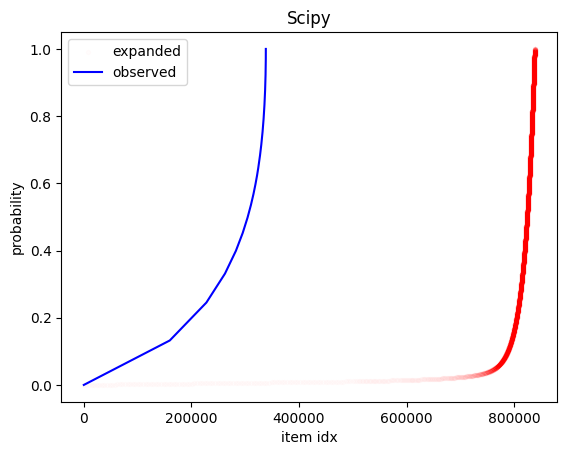

In [14]:
cdf_obs = np.cumsum(p_obs)    # cumulative distribution function of a random variable

max_i = 10000
u = [i/max_i for i in range(max_i + 1)]
X = (np.rint(prob_to_idx(u))).astype(int)
plt.title('Scipy')
plt.scatter(X, u, marker='.', alpha=0.01,color='red',label='expanded')
plt.plot(idx_list, cdf_obs,color='blue',label='observed')
plt.legend(loc='upper left')
plt.xlabel('item idx')
plt.ylabel('probability')
plt.show()

In [15]:
kl_divergence_obs_synth = entropy(p_obs, p_new[:len(p_obs)])
print(f"KL-divergence observed to synthetic: {kl_divergence_obs_synth}")
kl_divergence_synth_obs = entropy(p_new[:len(p_obs)], p_obs)
print(f"KL-divergence synthetic to observed: {kl_divergence_synth_obs}")


KL-divergence observed to synthetic: 4.227092959379588
KL-divergence synthetic to observed: 2.7754826594271176


In [16]:
mae = np.mean(np.abs(p_obs - p_new[:len(p_obs)]))  # mean absolute error
rmse = np.sqrt(np.mean(np.square(p_obs - p_new[:len(p_obs)])))  # root mean squared error
ks = np.max(np.abs(np.cumsum(p_obs) - np.cumsum(p_new[:len(p_obs)])))  # Kolmogorov-Smirnov statistic
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, KS: {ks:.4f}")

MAE: 0.0001, RMSE: 0.0003, KS: 25.0037
